In [1]:
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import backend as K

from scipy.io import wavfile # scipy library to read wav files
from scipy.fftpack import fft # fourier transform
from scipy import signal

import librosa.display
import pylab
import librosa    
import glob
import os
import pandas as pd
import numpy as np
import cv2
import subprocess
import matplotlib.pyplot as plt

# from utilities import f1_m, recall_m, precision_m

## Resources
- https://medium.com/gradientcrescent/urban-sound-classification-using-convolutional-neural-networks-with-keras-theory-and-486e92785df4


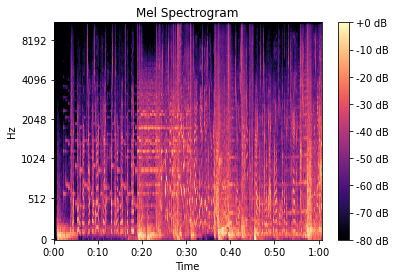

In [8]:
clip, sample_rate = librosa.load("test_audio.wav")
mel_spect = librosa.feature.melspectrogram(y=clip, sr=sample_rate)
mel_spect = librosa.power_to_db(mel_spect, ref=np.max)
librosa.display.specshow(mel_spect, y_axis='mel',x_axis='time')
plt.title('Mel Spectrogram')
plt.colorbar(format='%+2.0f dB')


In [2]:
# global variables
train_dir = os.getcwd() + "/train_data/"
val_dir = os.getcwd() + "/val_data/"
test_dir = os.getcwd() + "/test_data/"

train_audio_dir = os.getcwd() + "/audio_classification/extracted_train_audio/"
val_audio_dir = os.getcwd() + "/audio_classification/extracted_val_audio/"
test_audio_dir = os.getcwd() + "/audio_classification/extracted_test_audio/"

# Create a dataframe which contains multiclass classification content annotations for each video scene used in the training set.
train_df = pd.read_csv('train-updated.csv', dtype={'combination': object}).iloc[:,1:]
train_df["path"] = train_dir + train_df["Video ID"]+ ".0" + train_df["Scene_ID"].astype(str) + ".mp4"

# Create a dataframe which contains multiclass classification content annotations for each video scene used in the validation set.
val_df = pd.read_csv('val.csv', dtype={'combination': object}).iloc[:,1:]
val_df["path"] = val_dir + val_df["Video ID"]+ ".0" + val_df["Scene_ID"].astype(str) + ".mp4"

# Create a dataframe which contains multiclass classification content annotations for each video scene used in the test set.
test_df = pd.read_csv('test-updated.csv', dtype={'combination': object}).iloc[:,1:]
test_df["path"] = test_dir + test_df["Video ID"]+ ".0" + test_df["Scene_ID"].astype(str) + ".mp4"



## Train model

In [3]:
# Hyperparameters
IMG_SIZE = 224
EPOCHS = 30
BATCH_SIZE = 32

In [4]:
train_spectrograms = glob.glob('audio_classification/extracted_train_spectrogram/*')
val_spectrograms = glob.glob('audio_classification/extracted_val_spectrogram/*')
test_spectrograms = glob.glob('audio_classification/extracted_test_spectrogram/*')

train_labels = np.load("audio_classification/train_labels.npy")
val_labels = np.load("audio_classification/val_labels.npy")
test_labels = np.load("audio_classification/test_labels.npy")

In [5]:
from keras_preprocessing import image
train_data = []
val_data = []
test_data = []

for f in train_spectrograms:
    img = image.load_img(f, target_size= (IMG_SIZE,IMG_SIZE))
    img = image.img_to_array(img)
    train_data.append(img)
    
train_data = np.array(train_data)
print(train_data.shape)

for f in val_spectrograms:
    img = image.load_img(f, target_size= (IMG_SIZE,IMG_SIZE))
    img = image.img_to_array(img)
    val_data.append(img)
    
val_data = np.array(val_data)
print(val_data.shape)

for f in test_spectrograms:
    img = image.load_img(f, target_size= (IMG_SIZE,IMG_SIZE))
    img = image.img_to_array(img)
    test_data.append(img)
    
test_data = np.array(test_data)
print(test_data.shape)

(942, 224, 224, 3)
(113, 224, 224, 3)
(107, 224, 224, 3)


In [6]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

## Train model with SGD optimizer

In [7]:
def get_cnn_model():
    # # Create a VGG19 model, and removing the last layer that is classifying 1000 images. 
    # # This will be replaced with images classes we have. 
    # base_model = VGG19(include_top=True, input_shape=(IMG_SIZE,IMG_SIZE,3))
    # # freeze all layers in the the base model
    # # base_model.trainable = False

    # # Model = Model(inputs=base_model.input, outputs=base_model.get_layer('flatten').output)

    # # x = layers.Flatten()(base_model.output) #Output obtained on vgg19 is now flattened.
    # x = base_model.output
    # x = layers.Dense(4096, activation='relu')(x)
    # outputs = layers.Dense(4, activation="sigmoid")(x)

    # #Creating model object 
    # model = keras.Model(inputs=base_model.input, outputs=outputs)


    model_pretrained = VGG19(include_top=True, input_shape=(IMG_SIZE, IMG_SIZE, 3))#, weights="imagenet")
    x = layers.Dense(4096, activation='relu', name='predictions1', dtype='float32')(model_pretrained.layers[-2].output)
    output = layers.Dense(4, activation='sigmoid', name='predictions', dtype='float32')(x)
    model = Model(model_pretrained.input, output)


    # model = keras.Sequential()
    # model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(IMG_SIZE,IMG_SIZE,3)))
    # model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    # model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    # model.add(layers.Dropout(0.25))
    # model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
    # model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    # model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    # model.add(layers.Dropout(0.5))
    # model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
    # model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    # model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    # model.add(layers.Dropout(0.5))
    # model.add(layers.Flatten())
    # model.add(layers.Dense(512, activation='relu'))
    # model.add(layers.Dropout(0.5))
    # model.add(layers.Dense(4, activation='sigmoid'))




    # compile the model
    # optimizer = keras.optimizers.Adam(learning_rate=1e-4)
    # optimizer = keras.optimizers.SGD(learning_rate=10.0 ** (-1), decay=1e-5)
    # optimizer = keras.optimizers.RMSprop(lr=0.0005, decay=1e-6)
    optimizer = keras.optimizers.SGD(learning_rate=0.0000001, decay=1e-6, momentum=0.9, nesterov=True)
    # optimizer = keras.optimizers.SGD(learning_rate=0.0005, decay=1e-6, momentum=0.9)
    model.compile(
        optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy',f1_m,precision_m, recall_m]
    )

    model.summary()
    return model


In [8]:
def run_experiment():
    log_dir = "logs/fit/audio_chkpt_sgd" 
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

    filepath = os.getcwd() + "/audio_classification/audio_chkpt_sgd/audio_classifier"
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True,
        monitor='val_f1_m',
        mode='max',
        save_best_only=True,
        verbose = True
    )

    with tf.device('/device:CPU:0'):
        model = get_cnn_model()
        history = model.fit(
            train_data,
            train_labels,
            validation_data=(val_data,val_labels),
            epochs=EPOCHS,
            callbacks=[checkpoint, tensorboard_callback]
        )

    model.load_weights(filepath)
    # evaluate the model
    # _, accuracy = model.evaluate(test_data, test_labels)
   
    loss, accuracy, f1_score, precision, recall = model.evaluate(test_data, test_labels, verbose=0)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"F1 score: {round(f1_score, 2)}")
    print(f"Precision: {round(precision, 2)}")
    print(f"Recall: {round(recall, 2)}")

    return model

In [9]:
trained_model = run_experiment()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [10]:
y_pred = trained_model.predict(test_data)
y_pred = (y_pred > 0.5).astype(int)
# print(y_pred)


In [11]:
from sklearn.metrics import accuracy_score
print(accuracy_score(test_labels, y_pred))
from sklearn.metrics import classification_report
print(classification_report(test_labels, y_pred))

0.102803738317757
              precision    recall  f1-score   support

           0       0.24      0.92      0.39        24
           1       0.00      0.00      0.00        18
           2       0.00      0.00      0.00         6
           3       0.41      0.88      0.56        43

   micro avg       0.33      0.66      0.44        91
   macro avg       0.16      0.45      0.24        91
weighted avg       0.26      0.66      0.37        91
 samples avg       0.32      0.48      0.37        91



C:\Users\maitr\anaconda3\envs\tf.2.6\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\maitr\anaconda3\envs\tf.2.6\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\maitr\anaconda3\envs\tf.2.6\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Train model with Adam optimizer

In [15]:
def get_cnn_model_adam():
    model_pretrained = VGG19(include_top=True, input_shape=(IMG_SIZE, IMG_SIZE, 3))#, weights="imagenet")
    x = layers.Dense(4096, activation='relu', name='predictions1', dtype='float32')(model_pretrained.layers[-2].output)
    output = layers.Dense(4, activation='sigmoid', name='predictions', dtype='float32')(x)
    model = Model(model_pretrained.input, output)


    # compile the model
    optimizer = keras.optimizers.Adam(learning_rate=1e-4)
    # optimizer = keras.optimizers.RMSprop(lr=0.0005, decay=1e-6)
    # optimizer = keras.optimizers.SGD(learning_rate=0.0000001, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(
        optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy',f1_m,precision_m, recall_m]
    )

    model.summary()
    return model

In [16]:
def run_experiment_adam():
    log_dir = "logs/fit/audio_chkpt_adam" 
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

    filepath = os.getcwd() + "/audio_classification/audio_chkpt_adam/audio_classifier"
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True,
        monitor='val_f1_m',
        mode='max',
        save_best_only=True,
        verbose = True
    )

    with tf.device('/device:CPU:0'):
        model = get_cnn_model_adam()
        history = model.fit(
            train_data,
            train_labels,
            validation_data=(val_data,val_labels),
            epochs=EPOCHS,
            callbacks=[checkpoint, tensorboard_callback]
        )

    model.load_weights(filepath)
    # evaluate the model
    # _, accuracy = model.evaluate(test_data, test_labels)
   
    loss, accuracy, f1_score, precision, recall = model.evaluate(test_data, test_labels, verbose=0)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"F1 score: {round(f1_score, 2)}")
    print(f"Precision: {round(precision, 2)}")
    print(f"Recall: {round(recall, 2)}")

    return model

In [17]:
trained_model_adam = run_experiment_adam()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

## Train model using RMSProp optimizer

In [18]:
def get_cnn_model_rmsprop():
    model_pretrained = VGG19(include_top=True, input_shape=(IMG_SIZE, IMG_SIZE, 3))#, weights="imagenet")
    x = layers.Dense(4096, activation='relu', name='predictions1', dtype='float32')(model_pretrained.layers[-2].output)
    output = layers.Dense(4, activation='sigmoid', name='predictions', dtype='float32')(x)
    model = Model(model_pretrained.input, output)


    # compile the model
    # optimizer = keras.optimizers.Adam(learning_rate=1e-4)
    optimizer = keras.optimizers.RMSprop(lr=0.0005, decay=1e-6)
    # optimizer = keras.optimizers.SGD(learning_rate=0.0000001, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(
        optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy',f1_m,precision_m, recall_m]
    )

    model.summary()
    return model

In [19]:
def run_experiment_rmsprop():
    log_dir = "logs/fit/audio_chkpt_rmsprop" 
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

    filepath = os.getcwd() + "/audio_classification/audio_chkpt_rmsprop/audio_classifier"
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True,
        monitor='val_f1_m',
        mode='max',
        save_best_only=True,
        verbose = True
    )

    with tf.device('/device:CPU:0'):
        model = get_cnn_model_rmsprop()
        history = model.fit(
            train_data,
            train_labels,
            validation_data=(val_data,val_labels),
            epochs=EPOCHS,
            callbacks=[checkpoint, tensorboard_callback]
        )

    model.load_weights(filepath)
    # evaluate the model
    # _, accuracy = model.evaluate(test_data, test_labels)
   
    loss, accuracy, f1_score, precision, recall = model.evaluate(test_data, test_labels, verbose=0)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"F1 score: {round(f1_score, 2)}")
    print(f"Precision: {round(precision, 2)}")
    print(f"Recall: {round(recall, 2)}")

    return model

In [20]:
trained_model_rmsprop = run_experiment_rmsprop()

C:\Users\maitr\anaconda3\envs\tf.2.6\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

## Inference

In [ ]:
# from keras.preprocessing import image

# Y_pred = []

# for i in range(len(test_set)):
#   img = image.load_img(path= test_set.Images[i],target_size=(256,256,3))
#   img = image.img_to_array(img)
#   test_img = img.reshape((1,256,256,3))
#   img_class = classifier.predict_classes(test_img)
#   prediction = img_class[0]
#   Y_pred.append(prediction)

img = cv2.imread('extracted_test_spectrogram/al-TxOuSqc8.02.jpg')
img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
img = np.array(img)
# img = test_data[104]
img = img.reshape((1,IMG_SIZE,IMG_SIZE,3))
# print(img.shape)

y_pred = trained_model.predict(img)[0]

# # round probabilities to class labels
# y_pred = y_pred.round()


print(y_pred)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
melspectrogram=train_data.reshape(942,-1)
print(melspectrogram.shape)

In [ ]:
scaler.fit(melspectrogram)
normalized_melspectrogram = scaler.transform(melspectrogram)

print(np.amax(melspectrogram))
print(np.amax(normalized_melspectrogram))

In [ ]:
features_convolution = np.reshape(melspectrogram,(942,128, -1,1))
#melspectrogram=melspectrogram.reshape(400,128, -1)
features_convolution.shape